In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from sklearn import metrics
import seaborn as sns

In [3]:
# loading fashion mnist dataset

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])  #split data into train and validation

# convert dataset to dataloader to iterate over different batches
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

for x, y in test_loader:
    print(f"test data shape: {x.shape}")
    print(f"test data shape: {y.shape}")
    break


test data shape: torch.Size([64, 1, 28, 28])
test data shape: torch.Size([64])


In [4]:
def visualize(images, labels):
    fig, axes = plt.subplots(8, 8, figsize=(15, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {class_names[labels[i]]}')
        ax.axis('off')
    plt.show()

In [5]:
def visualize_predictions(model, images, labels):
    fig, axes = plt.subplots(8, 8, figsize=(15, 18))
    for i, ax in enumerate(axes.flat):
        pred = torch.argmax(model(images.to(device)), axis=1)
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = "green" if pred[i] == labels[i] else "red"
        ax.set_title(f'Label: {class_names[labels[i]]}\n pred: {class_names[pred[i]]}', color=color)
        ax.axis('off')

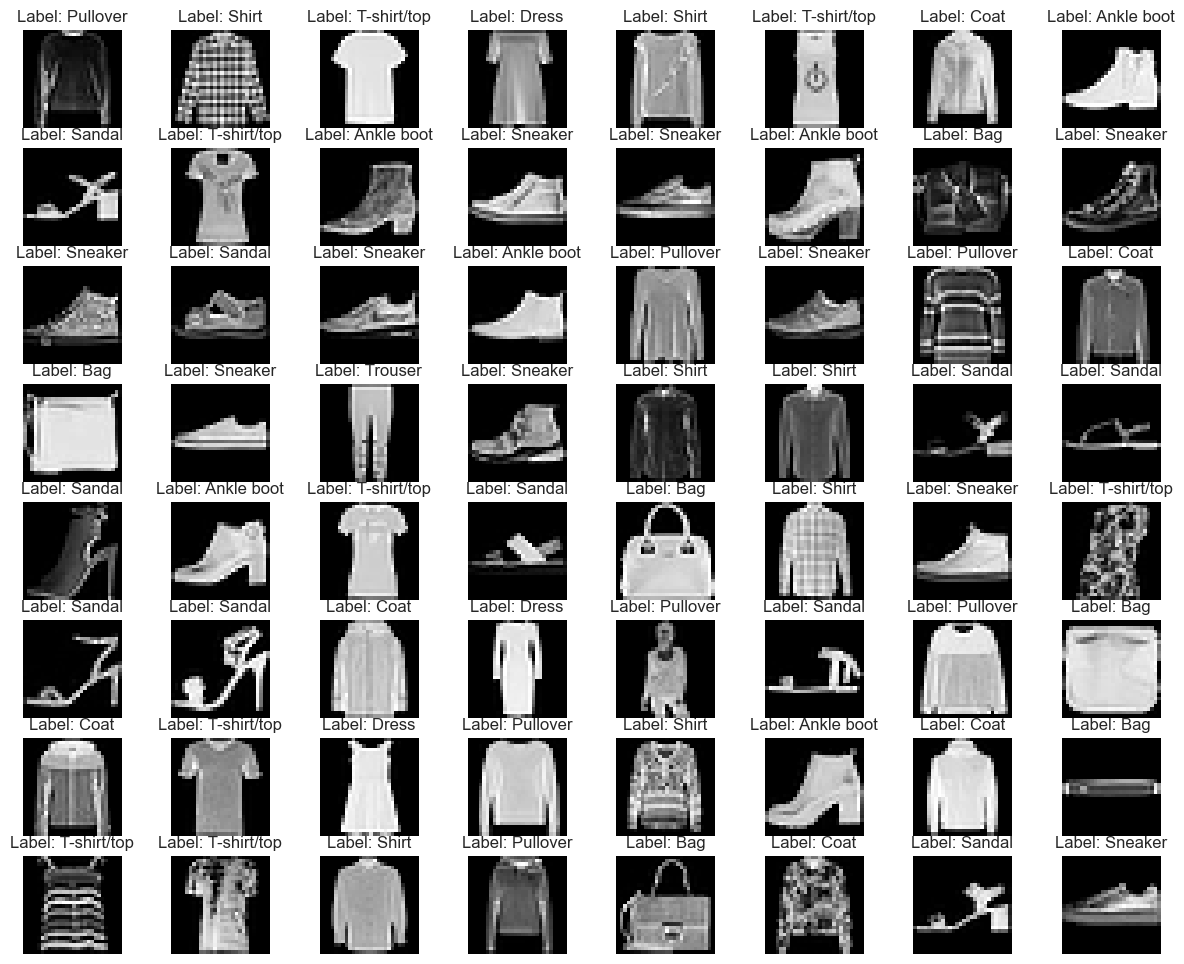

In [6]:
# visualize the first batch of dataloader
images, labels = next(iter(train_loader))

visualize(images, labels)

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"Using {device} device")


class NeuralNetwork(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Using cpu device


In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # effected by dropout or batch normalization while training
    size = len(dataloader.dataset)
    total_loss, correct = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)  # returns 10 values for 10 classes. the maximum value is the actual predicted class
        loss = loss_fn(pred, y)

        loss.backward()  # Gradients accumulate here(calculate gradients)
        optimizer.step()  # Updates with accumulated gradients(update parameters)
        optimizer.zero_grad()  # reset gradient to stop accumulating previous values

        total_loss += loss.item()  # loss in each batch
        correct += (pred.argmax(1) == y).type(torch.float).sum()  # sum of correct values for each batch
    return total_loss / len(dataloader), correct / size

In [11]:
def valid(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()  # is not effected by dropout or ... while training
    val_loss, correct = 0, 0
    with torch.no_grad():  # to not affect any grad tracking and save memory
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            val_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return val_loss / len(dataloader), correct / size

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()  # is not effected by dropout or ... while training
    test_loss, correct = 0, 0
    with torch.no_grad():  # to not affect any grad tracking and save memory
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / size

In [13]:
epochs = 100
val_loss_list, train_loss_list = [], []
val_acc_list, train_acc_list = [], []

for t in (pbar := trange(epochs)):
    loss, correct = train(train_loader, model, loss_fn, optimizer)
    train_acc_list.append(correct)
    train_loss_list.append(loss)
    val_loss, val_correct = valid(val_loader, model, loss_fn)
    val_acc_list.append(val_correct)
    val_loss_list.append(val_loss)
    pbar.set_description(
        f"Train loss: {loss:.4f}, Acc: {correct:.4f} | "
        f"Val loss: {val_loss:.4f}, Acc: {val_correct:.4f}"
    )

loss, correct = test(test_loader, model, loss_fn)
print(f"test loss: {loss:7f},test accuracy: {correct:7f}")

Train loss: 0.4156, Acc: 0.8551 | Val loss: 0.4321, Acc: 0.8512: 100%|██████████| 100/100 [1:52:02<00:00, 67.23s/it] 


test loss: 0.453347,test accuracy: 0.837900


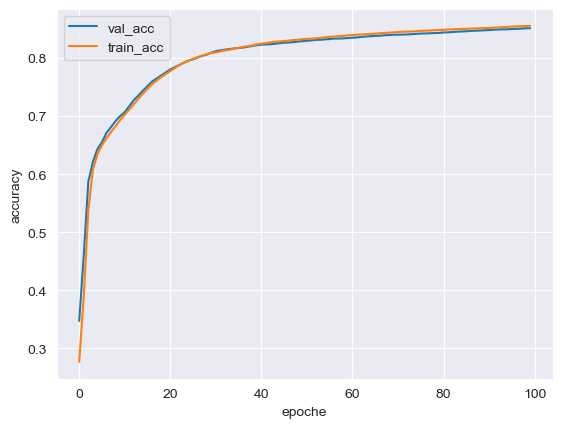

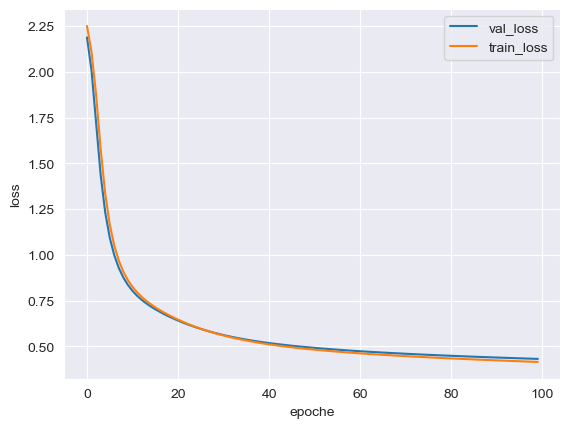

In [14]:
plt.plot(range(epochs), val_acc_list, label="val_acc")
plt.plot(range(epochs), train_acc_list, label="train_acc")
plt.xlabel("epoche")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(range(epochs), val_loss_list, label="val_loss")
plt.plot(range(epochs), train_loss_list, label="train_loss")
plt.xlabel("epoche")
plt.ylabel("loss")
plt.legend()
plt.show()

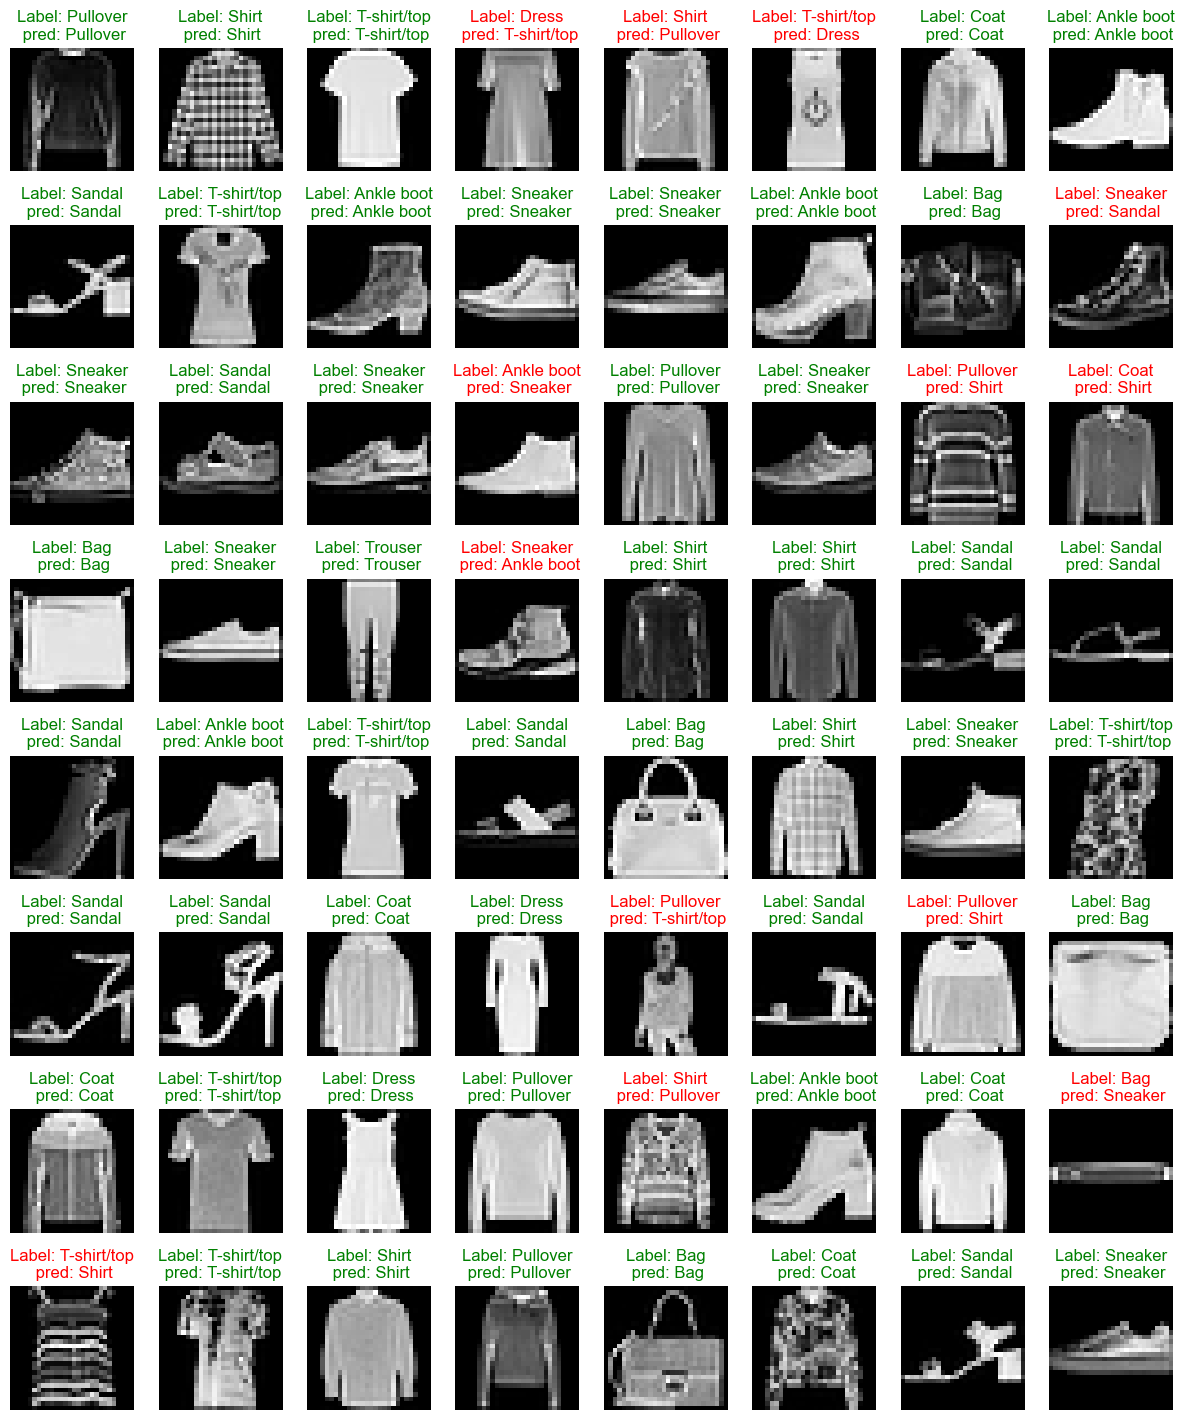

In [15]:
images, labels = next(iter(train_loader))
visualize_predictions(model, images, labels)

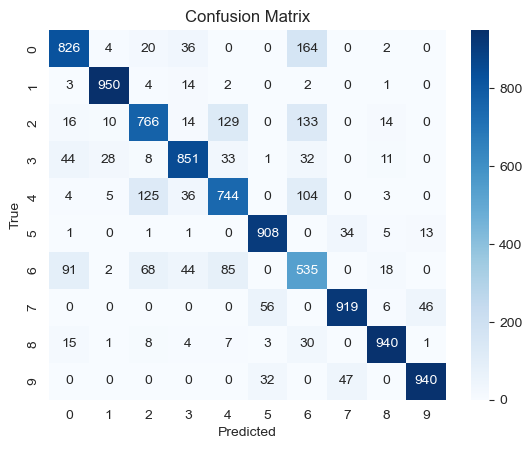

In [16]:
all_pred = []
all_label = []
with torch.no_grad():
    for batch, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        pred_labels = pred.argmax(axis=1)
        all_pred.append(pred_labels)
        all_label.append(y)

all_pred_arr = torch.cat(all_pred).to(device).numpy()
all_label_arr = torch.cat(all_label).to(device).numpy()
cm = metrics.confusion_matrix(all_pred_arr, all_label_arr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [17]:
def change_opt(dataloader, model, optimizer, n_epochs=1):
    loss_list = []
    acc_list = []
    if optimizer == "SGD":
        opti = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif optimizer == "AdaGrad":
        opti = torch.optim.Adagrad(model.parameters(), lr=1e-3)
    elif optimizer == "RMSProp":
        opti = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    elif optimizer == "Adam":
        opti = torch.optim.Adam(model.parameters(), lr=1e-3)

    for _ in (pbar := trange(n_epochs)):
        loss, acc = train(dataloader, model, loss_fn, opti)
        pbar.set_description(f"train loss: {loss:7f},train accuracy: {acc:7f}")
        loss_list.append(loss)
        acc_list.append(acc)

    return loss_list, acc_list

In [19]:
options = ['SGD', 'AdaGrad', 'RMSProp', 'Adam']

acc_dict = {}
loss_dict = {}
for opt in options:
    loss, acc = change_opt(train_loader, model, opt, 10)
    loss_dict[opt] = loss
    acc_dict[opt] = acc

train loss: 0.076878,train accuracy: 0.970625: 100%|██████████| 10/10 [09:18<00:00, 55.88s/it]


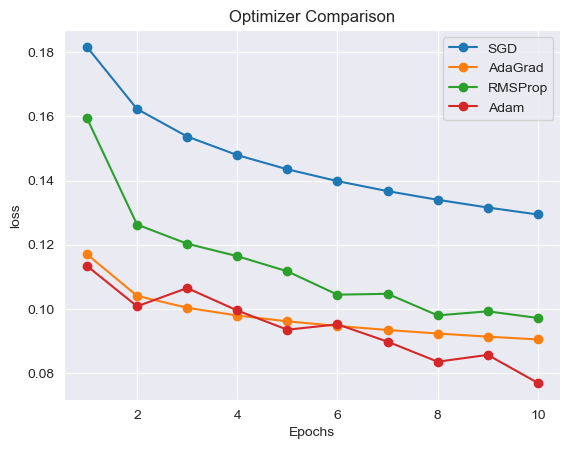

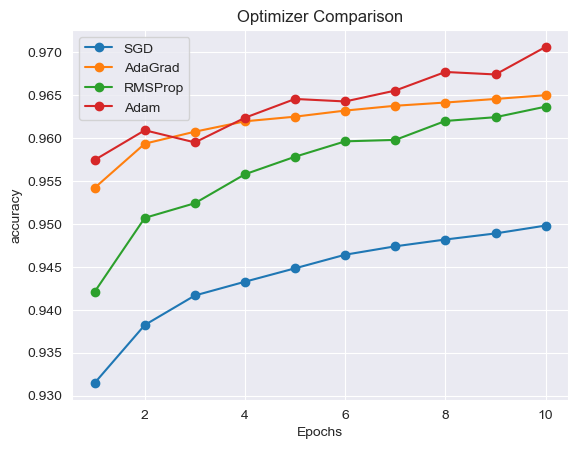

In [20]:
for optimizer, values in loss_dict.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=optimizer)

plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Optimizer Comparison")
plt.legend()
plt.grid(True)
plt.show()

for optimizer, values in acc_dict.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=optimizer)

plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Optimizer Comparison")
plt.legend()
plt.grid(True)
plt.show()